# Torch to ONNX Conversion

This notebook converts Torch to ONNX models.

In [1]:
1+1

2

In [2]:
import torch
import torch.nn as nn
import onnx
import dill
from onnx2torch import convert
import os
import matplotlib.pyplot as plt  # Add this line

In [3]:
import sys
sys.path.append('/Users/billb/github/nnUNet-Adjustment')


In [4]:
import nnunetv2.training.nnUNetTrainer

In [5]:
# Check if running on Mac OS
is_mac = os.name == 'posix' and os.uname().sysname == 'Darwin'
print('posix' if os.name == 'posix' else 'not posix')
print('mac' if is_mac else 'not mac')


posix
mac


In [6]:
# Set up paths
is_mac = os.name == 'posix' and os.uname().sysname == 'Darwin'
rootPath = "~/Projects/AWI/NetExploration/" if is_mac else '/mnt/SliskiDrive/AWI/AWIBuffer/' # '/Volumes/Crucial X8/AWIBuffer/'

In [7]:
rootPath="/Volumes/Crucial X8/AWIBuffer/"

In [8]:
# Set up device
gpuDevice = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {gpuDevice}") 

Using device: mps


## Test Model with Random Input

Import a dill PyTorch model

In [9]:
# torchModelPath = rootPath + "PlainConvUNet-nnUNetPlans_2d-DC_and_CE_loss-w-1-20-20-dill.pth"
torchModelPath = rootPath + "nnUNetResEncUNet_2d_-DC_and_CE_loss-w-1-20-20.pth"

In [10]:
torchModelPath

'/Volumes/Crucial X8/AWIBuffer/nnUNetResEncUNet_2d_-DC_and_CE_loss-w-1-20-20.pth'

In [11]:
# Check if exists file at path torchModelPath
if not os.path.exists(torchModelPath):
    raise FileNotFoundError(f"Model file not found at path: {torchModelPath}")

In [12]:
tmodel = nnUNetTrainer()

NameError: name 'nnUNetTrainer' is not defined

In [35]:
# Load the model
model = torch.load(torchModelPath,map_location=gpuDevice)

/var/folders/6r/53g1hjps2h90dmssmx5f4h_h0000gn/T/ipykernel_51381/1075232825.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(torchModelPath,map_locatio

In [36]:

model.eval()

# Test the model with a random input
random_tensor = torch.randn(1, 5, 512, 512, device=gpuDevice, dtype=torch.float32)
print("Input tensor shape:", random_tensor.shape)

AttributeError: 'dict' object has no attribute 'eval'

In [13]:
with torch.inference_mode():
    output = model(random_tensor)

print("Output tensor shape:", output.shape)


Output tensor shape: torch.Size([1, 3, 512, 512])


## Test Model with HDF5 Input

In [14]:
import platform

system = platform.system()
if "Darwin" in system:
    if os.path.isdir("/Volumes/Crucial X8"):
        dataDir = "/Volumes/Crucial X8/AWIBuffer"
    else:
        dataDir = "/Users/billb/Projects/AWI/NetExploration"
elif "Linux" in system:
    dataDir = "/mnt/SliskiDrive/AWI/AWIBuffer"
else:
    dataDir = None  # or some default path

angiogramH5Path = dataDir + "/AngiogramsDistilledUInt8List.h5"
angiogramH5Path

'/Volumes/Crucial X8/AWIBuffer/AngiogramsDistilledUInt8List.h5'

In [15]:
import h5py

# Open the HDF5 file and print all dataset keys
with h5py.File(angiogramH5Path, 'r') as f:
    # Get all keys at root level
    keys = list(f.keys())
    print("Dataset keys in HDF5 file:")
    for key in keys:
        print(f"- {key}")


Dataset keys in HDF5 file:
- 01_Case_CSF8U1R1_14_Left Coronary
- 01_Case_CSF8U1RQ_13_Left Coronary
- 03_Case_CSF8UKA1_2_Left Coronary
- 03_Case_CSF8UKA5_4_Left Coronary
- 03_Case_CSF8UKA9_1_Left Coronary
- 03_Case_CSF8UKAD_7_Left Coronary
- 03_Case_CSF8UKAH_5_Left Coronary
- 03_Case_CSF8UKAL_6_Left Coronary
- 06_Case_CSF8W343_9_Left Coronary
- 06_Case_CSF8W34C_7_Left Coronary
- 07_Case_CSF8W6FU_3_Left Coronary
- 07_Case_CSF8W6G1_5_Left Coronary
- 07_Case_CSF8W6G6_2_Left Coronary
- 07_Case_CSF8W6GE_7_Left Coronary
- 07_Case_CSF8W6GK_4_Left Coronary
- 07_Case_CSF8W6GS_8_Left Coronary
- 07_Case_CSF8W6GY_6_Left Coronary
- 08_Case_CSF8WG5Q_2
- 08_Case_CSF8WG66_23
- 08_Case_CSF8WG6J_3
- 08_Case_CSF8WG6P_24
- 10_Case_CSF8WNXU_5
- 10_Case_CSF8WNY6_1
- 11_Case_CSF8X20X_3
- 11_Case_CSF8X21K_13
- 11_Case_CSF8X226_2
- 12_Case_CSF8XAD2_23
- 12_Case_CSF8XADW_10
- 13_Case_CSVS1XAP_1
- 13_Case_CSVS1XAU_6
- 13_Case_CSVS1XB4_2
- 13_Case_CSVS1XBI_4
- 14_Case_CSVS23F6_14
- 14_Case_CSVS23FO_5
- 14_Case_CSV

In [16]:
# Load first angiogram from HDF5 file
import random
with h5py.File(angiogramH5Path, 'r') as f:
    # Get first key
    hdfKey = random.choice(keys)
    print(f"Loading dataset: {hdfKey}")
    # Load data into tensor
    agram = torch.from_numpy(f[hdfKey][:]).float()
    print(f"Loaded tensor shape: {agram.shape}")


Loading dataset: Napari_31_rev
Loaded tensor shape: torch.Size([76, 512, 512])


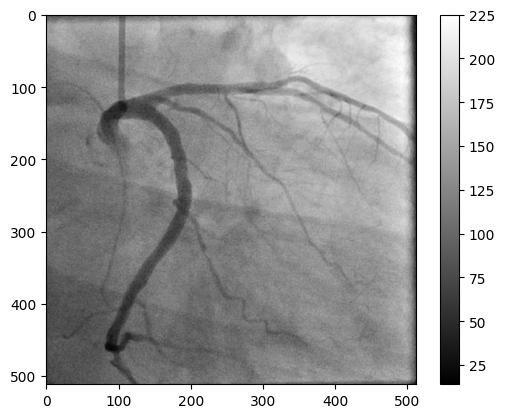

In [17]:
#Display the 30th frame of the angiogram
plt.imshow(agram[30], cmap='gray')
plt.colorbar()
plt.show()


In [18]:
# Normalize angiogram by subtracting mean and dividing by standard deviation
xagram = (agram - agram.mean()) / agram.std()
print(f"Normalized tensor shape: {xagram.shape}")


Normalized tensor shape: torch.Size([76, 512, 512])


In [19]:
# Create input tensor with 5 consecutive frames centered around frame 30
start_idx = 28  # 30-2 to get 2 frames before
end_idx = 33    # 30+3 to get 2 frames after (exclusive)
z = xagram[start_idx:end_idx].unsqueeze(0)  # Add batch dimension
print(f"Input tensor shape: {z.shape}")


Input tensor shape: torch.Size([1, 5, 512, 512])


In [20]:
z = z.to(gpuDevice)

In [21]:
y=model(z)
y.shape

torch.Size([1, 3, 512, 512])

In [23]:
# Apply softmax along dimension 1 (second dimension) which has size 3
y = torch.nn.functional.softmax(y, dim=1)
print(f"Output tensor shape after softmax: {y.shape}")


Output tensor shape after softmax: torch.Size([1, 3, 512, 512])


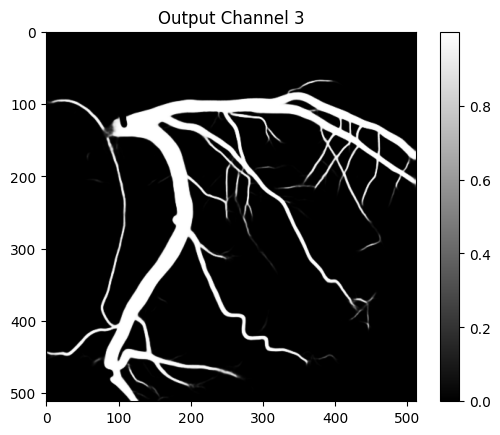

In [24]:
# Display the 3rd channel (index 2) of the output
plt.imshow(y[0, 2].cpu().detach().numpy(), cmap='gray')
plt.colorbar()
plt.title('Output Channel 3')
plt.show()


In [25]:
# Calculate number of valid frame groups (each group has 5 consecutive frames)
num_frames = xagram.shape[0]
num_groups = num_frames - 4  # Each group needs 5 frames

# Create tensor to hold all valid frame groups
z5 = torch.zeros((num_groups, 5, 512, 512))

# Fill z5 with overlapping groups of 5 consecutive frames
for i in range(num_groups):
    z5[i] = xagram[i:i+5]

print(f"Shape of tensor containing all valid 5-frame groups: {z5.shape}")


Shape of tensor containing all valid 5-frame groups: torch.Size([72, 5, 512, 512])


In [26]:
# Feed z5 into the model and get the output
y5 = model(z5.to(gpuDevice))
y5.shape

torch.Size([72, 3, 512, 512])

In [27]:
# Apply softmax along dimension 1 (second dimension) which has size 3
ys5 = torch.nn.functional.softmax(y5, dim=1)
print(f"Output tensor shape after softmax: {ys5.shape}")


Output tensor shape after softmax: torch.Size([72, 3, 512, 512])


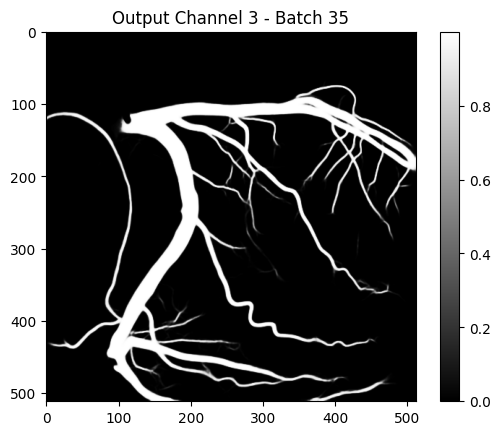

In [28]:
# Display the 3rd channel (index 2) of batch member 35
plt.imshow(ys5[35, 2].cpu().detach().numpy(), cmap='gray')
plt.colorbar()
plt.title('Output Channel 3 - Batch 35')
plt.show()


## Export to ONNX

In [29]:
# Export model back to ONNX
onnxOutputPath = torchModelPath.replace(".pth", ".onnx")


In [30]:
onnxOutputPath

'/Volumes/Crucial X8/AWIBuffer/PlainConvUNet-nnUNetPlans_2d-DC_and_CE_loss-w-1-20-20-dill.onnx'

In [31]:

# Move both model and input tensor to CPU for export
# model_for_export = modelPerOnnx.to(gpuDevice)
# input_for_export = z5.to(gpuDevice)

# with torch.inference_mode():
#     torch.onnx.export(modelPerOnnx,
#                      random_tensor,
#                      onnxOutputPath, 
#                      export_params=True,
#                      opset_version=18, 
#                      do_constant_folding=True,
#                      verbose=True,
#                      input_names=['input'],
#                      output_names=['output'], 
#                      dynamic_axes={'input': {0: 'batch_size'}, 
#                                  'output': {0: 'batch_size'}}, 
#                      training=torch.onnx.TrainingMode.EVAL)

with torch.inference_mode():
    torch.onnx.export(model,
                     random_tensor,
                     onnxOutputPath, 
                     export_params=True,
                     do_constant_folding=True,
                     verbose=False)


/Users/billb/.venv/nnunetv2/lib/python3.10/site-packages/torch/onnx/symbolic_helper.py:1454: UserWarning: ONNX export mode is set to TrainingMode.EVAL, but operator 'instance_norm' is set to train=True. Exporting with train=True.
  warnings.warn(
